In [6]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# hyperparams
num_epochs = 4
batch_size = 4
learning_rate = 0.001

In [7]:
# dataset has PILImage images of range [0, 1]
# we transform them to tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [8]:
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10/', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data/CIFAR10', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

170499072it [00:19, 8610789.81it/s]                                


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/
Files already downloaded and verified


In [9]:
classes =('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

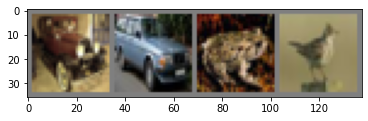

In [17]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [18]:
images.shape # = (batchSize, nColorChannels, nPixWidth, nPixHeight)

torch.Size([4, 3, 32, 32])

In [19]:
# Conv layer: outputSize = (InputWidth - FilterSize + 2*Padding)/Stride + 1

In [20]:
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

print(images.shape)
x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 10, 10])
torch.Size([4, 16, 5, 5])


In [10]:
# Conv net architecture
# Input -> Conv + Relu + Pooling -> Conv + Relu + Pooling -> ... -> Flatten -> Fully Connected -> Softmax
# where {(Conv + Relu + Pooling)} are for feature learning and 
# {(flatten, fully connected, softmax)} are for classification

In [23]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input color channels, 6 output channels, 5 kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, since self.conv1 produce 6 output channels
        self.fc1 = nn.Linear(16*5*5, 120) # Why 16*5*5? See Cell above for experimental results
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [24]:
model = ConvNet().to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
n_total_steps = len(train_loader)
n_total_steps

12500

In [28]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [4, 3, 32, 32]
        # input layer: 3 color channels, 6 output channels, kernel size = 5
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%4000 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{n_total_steps}, Loss = {loss.item():.4f}")

print('Training finished')
PATH = "./cnn.pth"
torch.save(model.state_dict(), PATH)

Epoch 1/4, Step 4000/12500, Loss = 2.3238
Epoch 1/4, Step 8000/12500, Loss = 1.8320
Epoch 1/4, Step 12000/12500, Loss = 1.7201
Epoch 2/4, Step 4000/12500, Loss = 1.8855
Epoch 2/4, Step 8000/12500, Loss = 1.8574
Epoch 2/4, Step 12000/12500, Loss = 1.4882
Epoch 3/4, Step 4000/12500, Loss = 2.6771
Epoch 3/4, Step 8000/12500, Loss = 1.4157
Epoch 3/4, Step 12000/12500, Loss = 2.8477
Epoch 4/4, Step 4000/12500, Loss = 1.4182
Epoch 4/4, Step 8000/12500, Loss = 1.6131
Epoch 4/4, Step 12000/12500, Loss = 1.9859
Training finished


In [29]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0] * 10
    n_class_samples = [0] * 10
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # return: max value, max index
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
    acc = 100 * n_correct / n_samples 
    print(f"Test accuracy: {acc:.2f}%")

    for i in range(10):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f"Test accuracy of classes[{i}]: {acc:.2f}%")

Test accuracy: 46.96%
Test accuracy of classes[0]: 39.70%
Test accuracy of classes[1]: 74.40%
Test accuracy of classes[2]: 21.30%
Test accuracy of classes[3]: 28.50%
Test accuracy of classes[4]: 42.50%
Test accuracy of classes[5]: 38.50%
Test accuracy of classes[6]: 69.00%
Test accuracy of classes[7]: 42.80%
Test accuracy of classes[8]: 75.20%
Test accuracy of classes[9]: 37.70%
